# Introduction

### Identity

=== **Milestone 2** ===

Nama : Teguh Sukmanaputra <br>
Batch : RMT-029


Project ini merupakan sebuah supervised machine learning model yang bertujuan untuk memprediksi klasifikasi kualitas air yang layak minum berdasarkan fitur-fiturnya. Pada permodelannya, project ini akan menggunakan beberapa model algoritma seperti KNN, SVM, Decision Tree, dan Random Forest yang kemudian akan dikombinasikan melalui teknik Ensemble Learning untuk menghasilkan sebuah model baru yang lebih kuat dan akurat. 

### Dataset Overview

Dataset yang digunakan pada project ini merupakan data terkait kualitas air dari beragam sampel air yang didasarkan pada berbagai parameter pengukuran karakteristik dan kandungan air. 

Sumber Dataset: <br>
https://www.kaggle.com/datasets/adityakadiwal/water-potability

Berikut merupakan deskripsi fitur-fitur yang ada didalam dataset:  
1. `ph`: Nilai pH air (rentang 0-14).
2. `Hardness`: Nilai kapasitas air untuk mengendapkan sabun yang disebabkan oleh Kalsium dan Magnesium (mg/L).
3. `Solids`: Nilai Total Dissolved Solids (TDS)/jumlah padatan terlarut dalam air (ppm).
4. `Chloramines`: Jumlah Chloramines dalam air (ppm).
5. `Sulfate`: Jumlah Sulfates terlarut dalam air (mg/L).
6. `Conductivity`: Tingkat Electrical conductivity air (μS/cm).
7. `Organic_carbon`: Jumlah Organic Carbon dalam air (ppm).
8. `Trihalomethanes`: Jumlah Trihalomethanes dalam air (μg/L).
9. `Turbidity`: Tingkat kekeruhan/Pengukuran kemampuan pancaran cahaya air (NTU).
10. `Potability`: Indikasi keamanan air untuk dikonsumsi (1=Layak/Berpotensi Konsumsi; 0=Tidak Layak).

- Keterangan satuan ukur:
    + ppm: parts per million
    + μg/L: microgram per liter
    + mg/L: milligram per liter
    + µS/cm: microsiemens per centimeter (unit in the category of Electric conductivity)
    + NTU: Nephelometric Turbidity Unit (the unit used to measure the turbidity)


---

# Import Libraries

In [103]:
# Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.feature_selection import f_oneway
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

---

# Data Loading

In [5]:
# Load dataset
df = pd.read_csv('water_potability.csv')

In [3]:
# Salinan dataset
df_copy = df.copy()

In [4]:
# Data Overview
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [5]:
# Duplicates check
df.duplicated().sum()

0

Tidak terdapat data duplicates.

In [6]:
# Missing value check
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Dapat terlihat bahwa terdapat cukup banyak missing value pada dataset ini yaitu pada kolom `pH`, `Sulfate`, dan `Trihalomethanes`.

---

# Exploratory Data Analysis (EDA)

### Potability Data Proportion

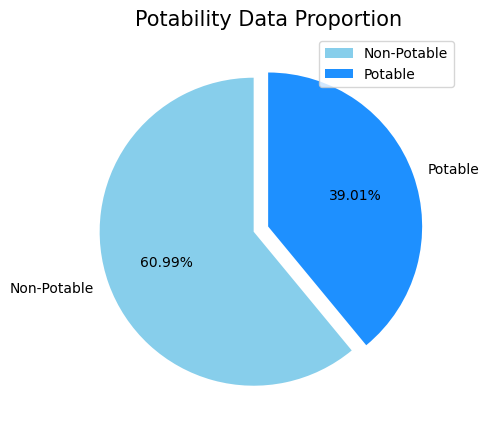

In [93]:
# Data class proportion
# Pie chart
labels = ['Non-Potable', 'Potable']
size = df['Potability'].value_counts()
colors = ['skyblue', 'dodgerblue']
explode = [0.1, 0]

fig, axes = plt.subplots(figsize=(10, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, startangle = 90, autopct = '%.2f%%')
plt.title('Potability Data Proportion', fontsize = 15)
plt.legend()
plt.show()

Dapat diketahui bahwa proporsi kelas klasifikasi pada dataset ini tidak seimbang, yang mana dataset ini didominasi oleh data kelas Non-Potable(0) yaitu sebesar 61% dan data kelas Potable(1) sebesar 39%. Adanya ketidakseimbangan proporsi data kelas ini dapat berpotensi adanya bias ketika training model sehingga akan menurunkan performa model dalam melakukan prediksi.

### Features Data Distribution

#### a.) Distribution - pH

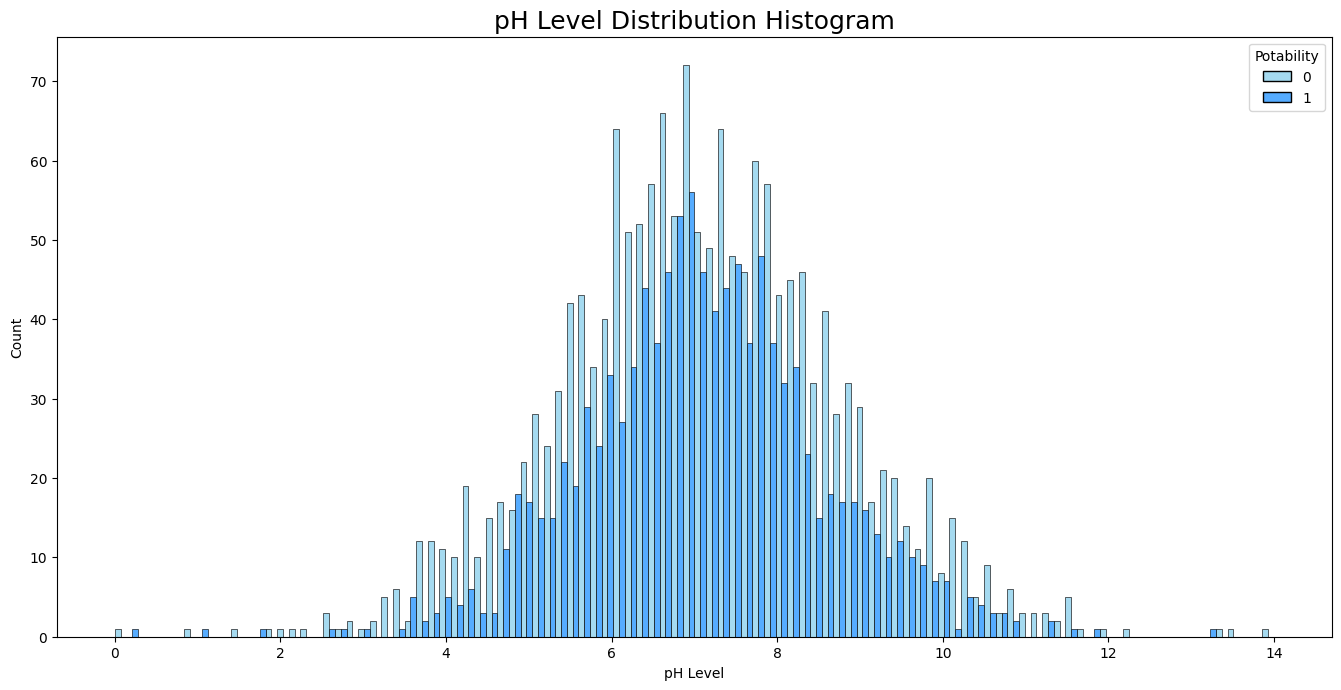

In [114]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='ph', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('pH Level')
plt.ylabel('Count')
plt.title('pH Level Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

Berdasarkan visualisasi dari histogram, secara keseluruhan data pH dapat dikatakan berdistribusi normal, namun masih dapat terlihat beberapa data di ujung kiri dan kanan histogram yang bisa saja terindikasi sebagai extreme values/outliers. Terkait tentang ph air, ph sendiri merupakan sebuah tingkat asam-basa sebuah materi. Adapun tingkat pH pada air konsumsi biasanya berkisar pada 6.5-8.5, yang mana pada histogram ini dapat kita ihat bahwa air yang layak konsumsi (potable) banyak berkumpul di rentang pH 6-8.

#### b.) Distribution - Hardness

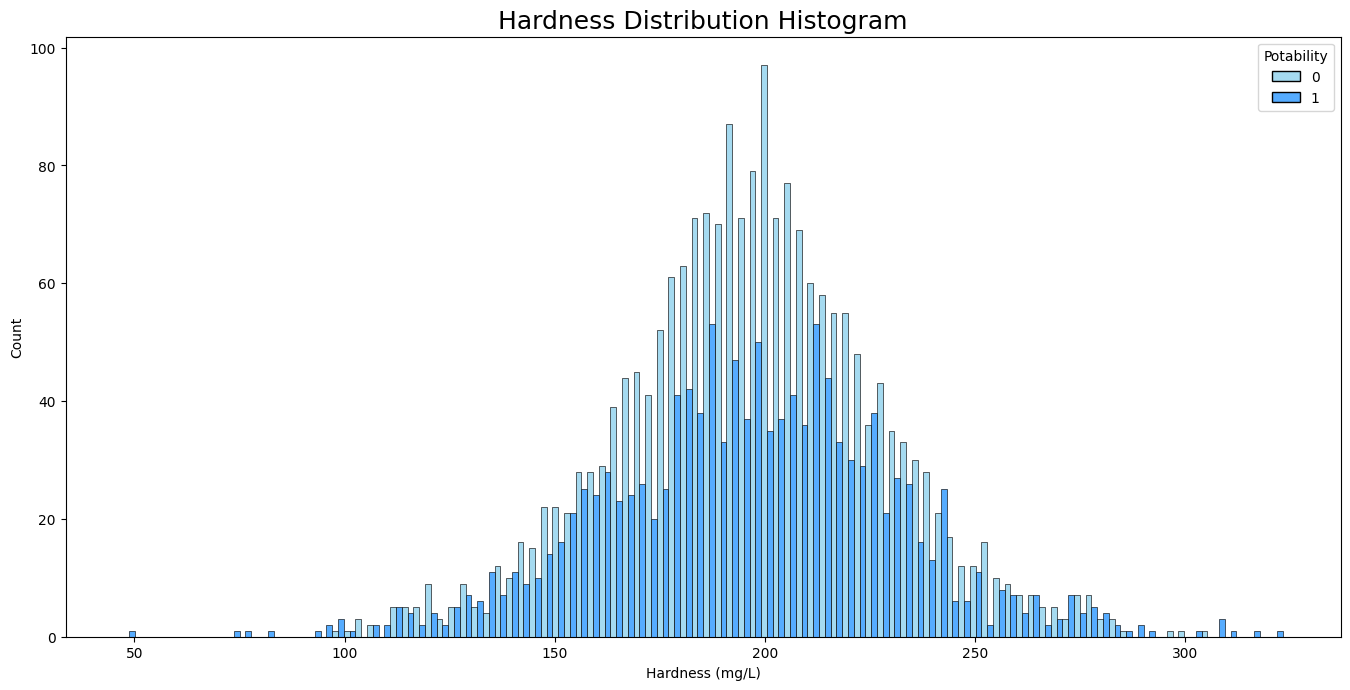

In [115]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Hardness', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Hardness (mg/L)')
plt.ylabel('Count')
plt.title('Hardness Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()


#### c.) Distribution - Solids

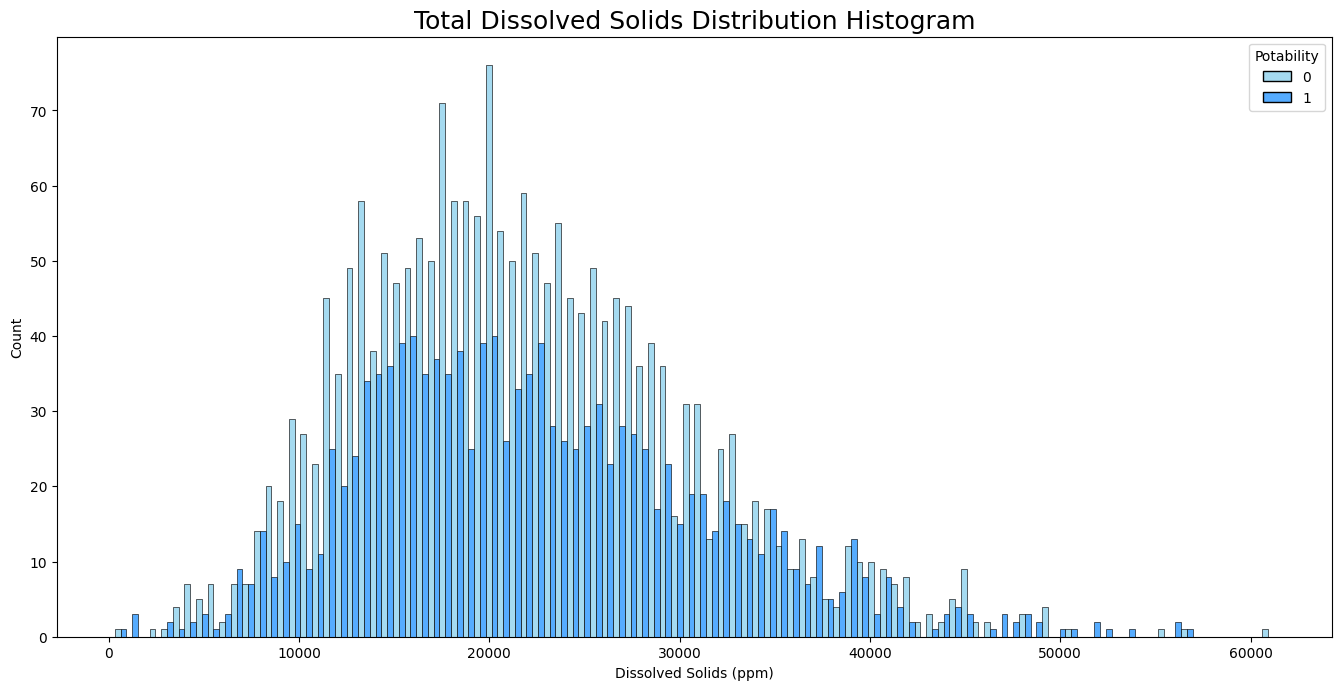

In [116]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Solids', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Dissolved Solids (ppm)')
plt.ylabel('Count')
plt.title('Total Dissolved Solids Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### d.) Distribution - Chloramines

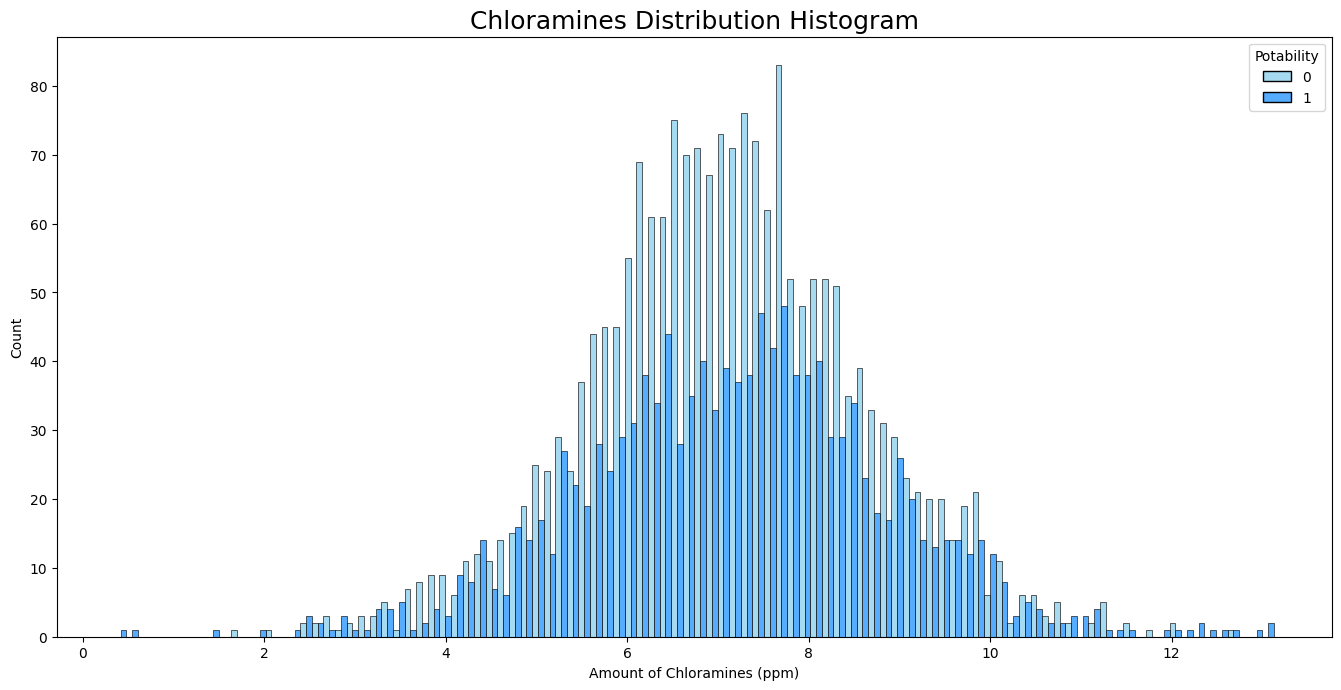

In [118]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Chloramines', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Amount of Chloramines (ppm)')
plt.ylabel('Count')
plt.title('Chloramines Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### e.) Distribution - Sulfate

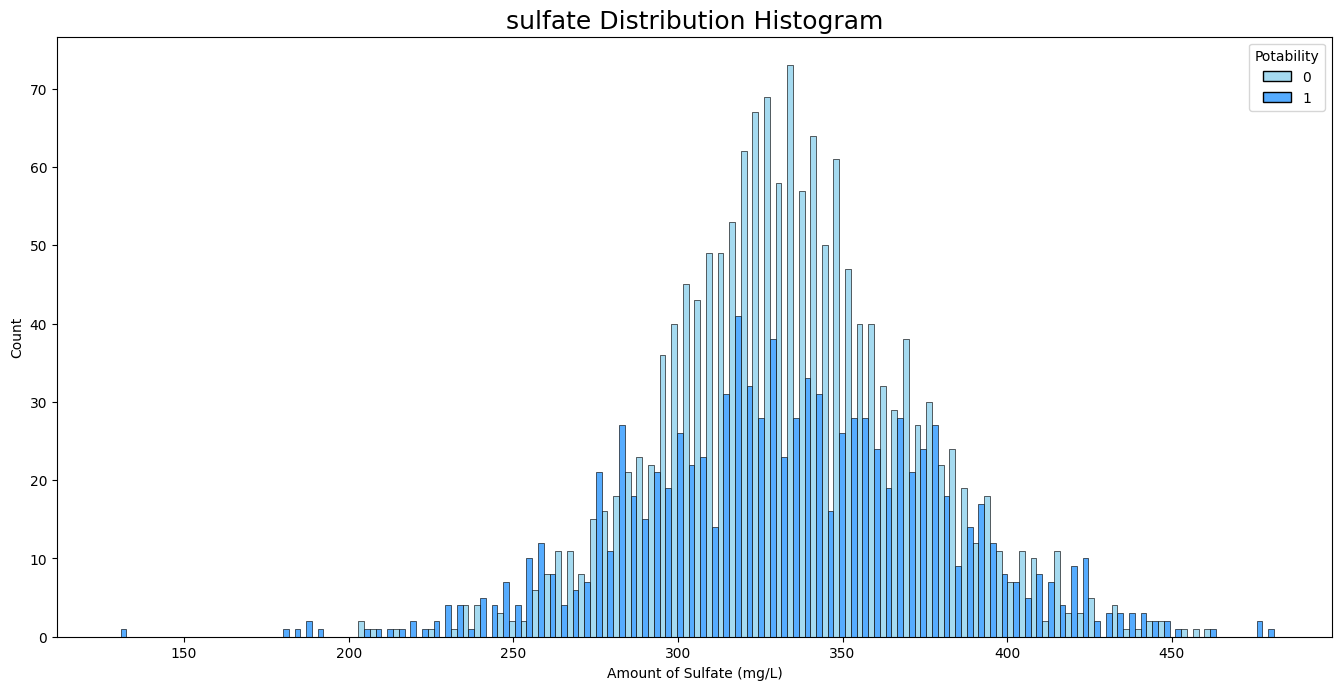

In [126]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Sulfate', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Amount of Sulfate (mg/L)')
plt.ylabel('Count')
plt.title('Sulfate Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### f.) Distribution - Conductivity

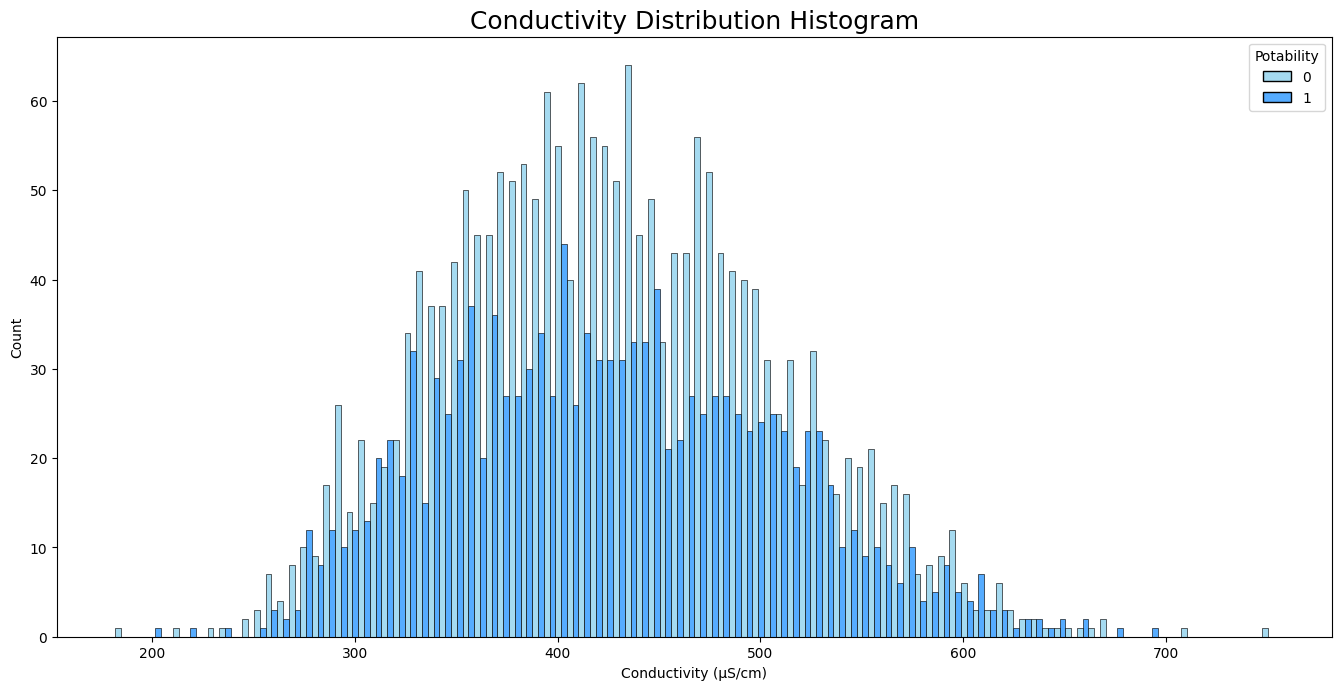

In [125]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Conductivity', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Conductivity (μS/cm)')
plt.ylabel('Count')
plt.title('Conductivity Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### g.) Distribution - Organic Carbon

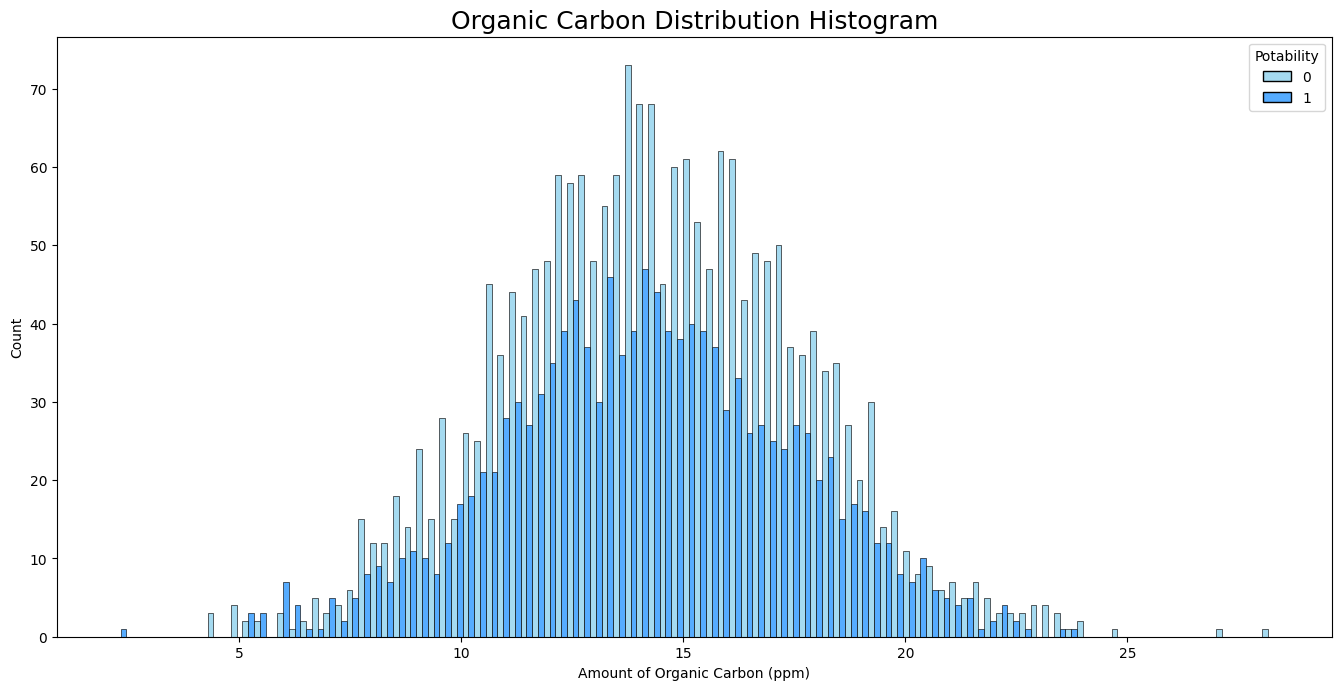

In [124]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Organic_carbon', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Amount of Organic Carbon (ppm)')
plt.ylabel('Count')
plt.title('Organic Carbon Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### h.) Distribution - Trihalomethanes

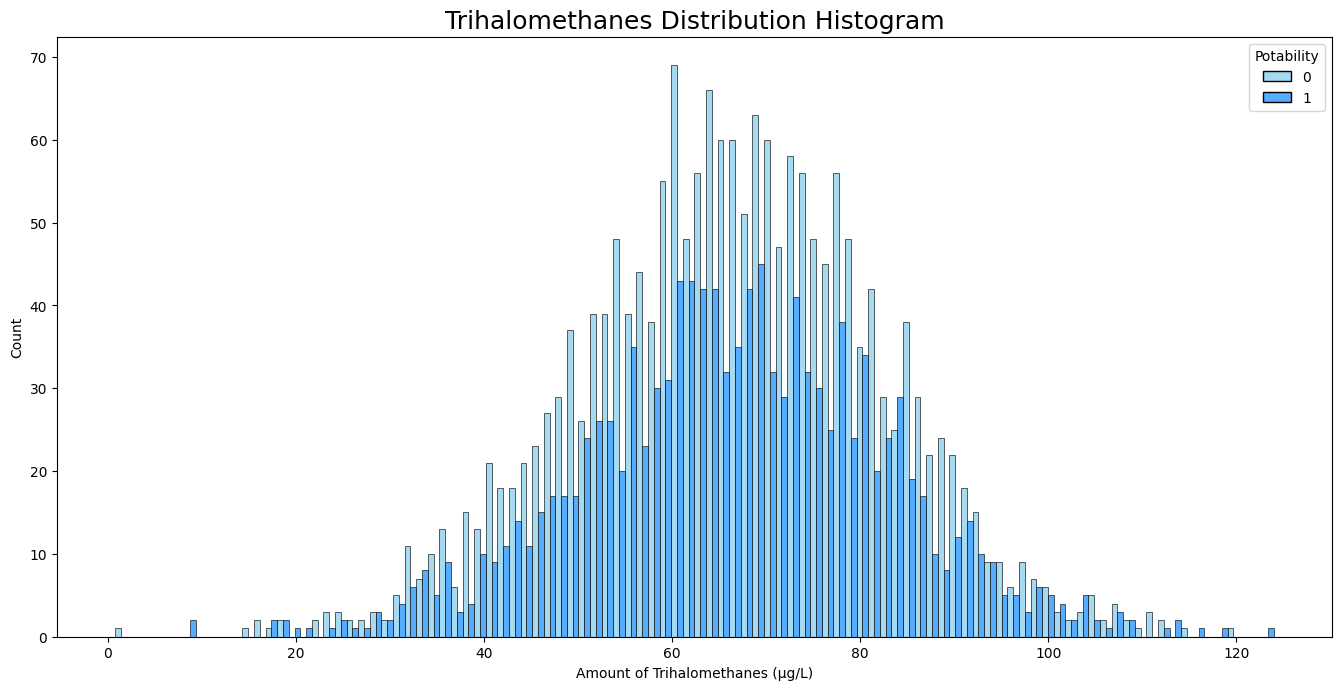

In [123]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Trihalomethanes', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Amount of Trihalomethanes (μg/L)')
plt.ylabel('Count')
plt.title('Trihalomethanes Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

#### i.) Distribution - Turbidity

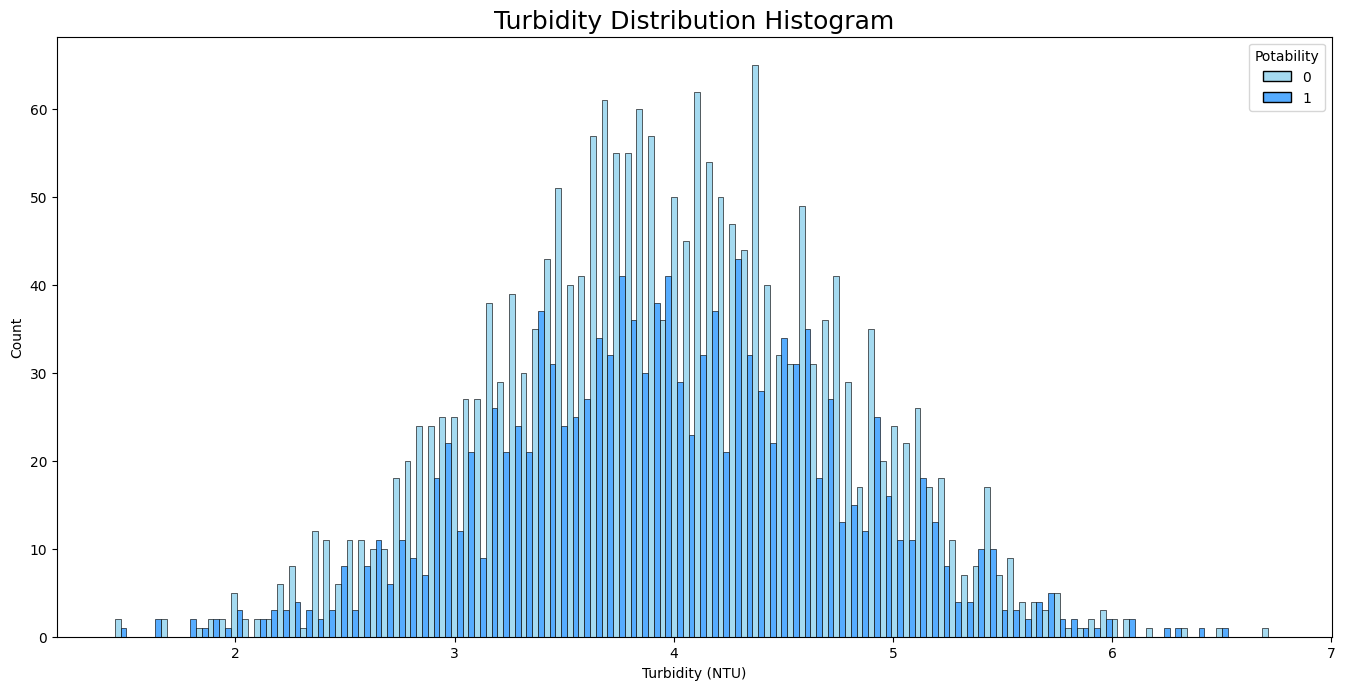

In [122]:
# Create histogram
plt.figure(figsize=(17, 8))
sns.histplot(data=df, x='Turbidity', hue='Potability', bins=100, multiple='dodge', palette=['skyblue', 'dodgerblue'])
plt.xlabel('Turbidity (NTU)')
plt.ylabel('Count')
plt.title('Turbidity Distribution Histogram', fontsize=18)

# Adjust figure layout
plt.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)

# Show figure
plt.show()

### Data Correlation

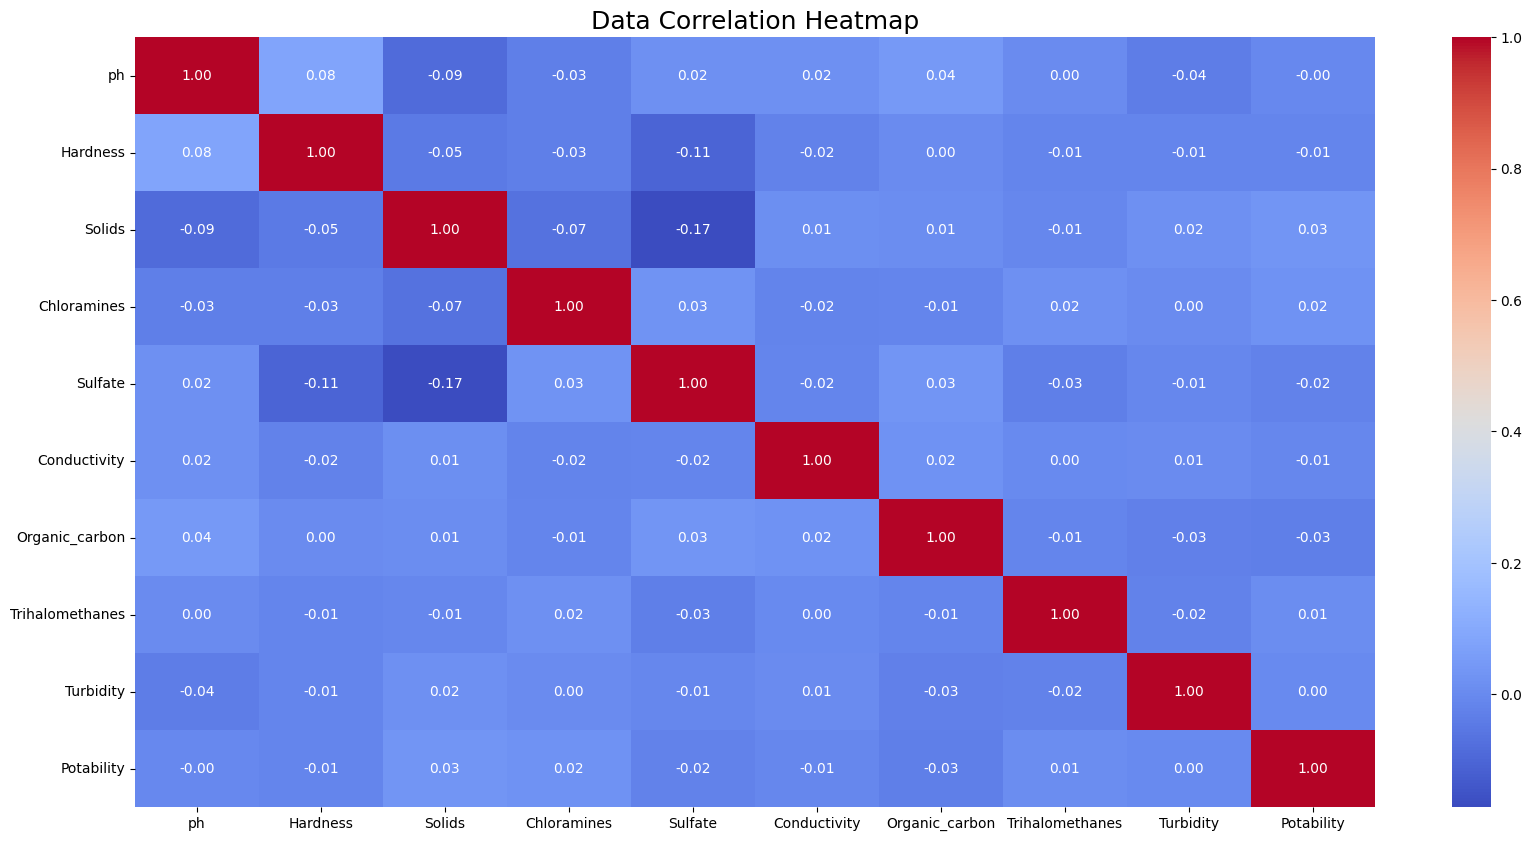

In [138]:
# Create correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Data Correlation Heatmap', fontsize=18)
plt.show()

Berdasarkan heatmap diatas, dapat diketahui bahwa korelasi antar data dalam dataset ini sangatlah kecil. Menurut saya, hal ini menandakan bahwa data yang ada kurang memuaskan karena jika dianalisa lebih dalam maka seharusnya karakteristik/parameter air seharusnya akan saling berkaitan, misalnya jika kandungan organic carbon dalam air meningkat maka biasanya tingkat pH air akan menurun (menjadi asam) serta secara tidak langsung akan menyebabkan air menjadi keruh atau sulit memencar cahaya (turbiditas menigkat).

---

# Feature Engineering 

### Handling Missing Values

In [4]:
# Missing values proportion
miss_val_proportion = (df.isnull().sum() / len(df))*100
print(miss_val_proportion)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64


Dikarenakan jumlah/proporsi missing values yang cukup banyak, maka dapat dilakukan pengisian/imputasi nilai menggunakan mean atau median agar tidak banyak data yang terbuang.

In [5]:
# Data describe untuk data Non-Potability
df[df['Potability'] == 0].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1684.000000,1998.000000,1998.000000,1998.000000,1510.000000,1998.000000,1998.000000,1891.000000,1998.000000,1998.0
mean,7.085378,196.733292,21777.490788,7.092175,334.564290,426.730454,14.364335,66.303555,3.965800,0.0
std,1.683499,31.057540,8543.068788,1.501045,36.745549,80.047317,3.334554,16.079320,0.780282,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.037723,177.823265,15663.057382,6.155640,311.264006,368.498530,12.101057,55.706530,3.444062,0.0
50%,7.035456,197.123423,20809.618280,7.090334,333.389426,422.229331,14.293508,66.542198,3.948076,0.0
75%,8.155510,216.120687,27006.249009,8.066462,356.853897,480.677198,16.649485,77.277704,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


In [6]:
# Data describe untuk data Non-Potability
df[df['Potability'] == 1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1101.000000,1278.000000,1278.000000,1278.000000,985.000000,1278.000000,1278.000000,1223.000000,1278.000000,1278.0
mean,7.073783,195.800744,22383.991018,7.169338,332.566990,425.383800,14.160893,66.539684,3.968328,1.0
std,1.448048,35.547041,9101.010208,1.702988,47.692818,82.048446,3.263907,16.327419,0.780842,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.179312,174.330531,15668.985035,6.094134,300.763772,360.939023,12.033897,56.014249,3.430909,1.0
50%,7.036752,196.632907,21199.386614,7.215163,331.838167,420.712729,14.162809,66.678214,3.958576,1.0
75%,7.933068,218.003420,27973.236446,8.199261,365.941346,484.155911,16.356245,77.380975,4.509569,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


Berdasarkan data describe dari kedua kategori potability, diasumsikan bahwa data cukup terdistribusi normal karena nilai standar deviasinya yang cukup rendah, namun untuk menghindari adanya pergeseran central tendency dan pengaruh outliers maka diputuskan untuk menggunakan median sebagai imputasi.

In [7]:
# Median dictionary
median_non_potability = df[df['Potability'] == 0][['ph','Sulfate','Trihalomethanes']].median().to_dict()
median_potability = df[df['Potability'] == 1][['ph','Sulfate','Trihalomethanes']].median().to_dict()

# Convert median dictionaries to dataFrame
median_0 = pd.DataFrame([median_non_potability.values()], columns=median_non_potability.keys())
median_1 = pd.DataFrame([median_potability.values()], columns=median_potability.keys())

# Merge dataframe
merge_median = pd.concat([median_0, median_1], ignore_index=True)
merge_median['Potability'] = ['0', '1']
merge_median.set_index(['Potability'])

,ph,Sulfate,Trihalomethanes
Potability,,,
0,7.035456,333.389426,66.542198
1,7.036752,331.838167,66.678214


Berdasarkan perbandigan antara median untuk data non-potable dan potable, dapat terlihat bahwa perbedaan diantara keduanya cukup kecil sehingga dapat menggunakan median keseluruhan data sebagai imputasi untuk missing values.

In [8]:
# Generate median sebagai imputation
df['ph'].fillna(value=df['ph'].median(),inplace=True)
df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_12292\1318433361.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ph'].fillna(value=df['ph'].median(),inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1318433361.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [9]:
# Cek missing values
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### Splitting X (Features) & Y (Target)

In [10]:
# Memisah X dan Y
X = df.drop(['Potability'], axis=1)
y = df['Potability']
X.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


### Splitting Training & Test

In [11]:
# Memisah train-set dan test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (2457, 9)
Test Size:  (819, 9)


### Handling Outliers - Train Set

In [12]:
# List nama features
feature_list = X_train.columns

# Menghitung nilai skewness tiap features
item = []
for col in feature_list:
  item.append([col, X_train[col].skew()])

feature_skew = pd.DataFrame(columns=['nama_kolom', 'nilai_skewness'], data= item)
feature_skew

,nama_kolom,nilai_skewness
0,ph,0.046936
1,Hardness,-0.029208
2,Solids,0.663432
3,Chloramines,-0.039178
4,Sulfate,-0.024358
5,Conductivity,0.281756
6,Organic_carbon,0.018261
7,Trihalomethanes,-0.107771
8,Turbidity,-0.010875


Berdasarkan uji normalitas menggunakan nilai skewness, dapat diasumsikan bahwa features pada Train Set berdistribusi normal sehingga dapat dilakukan penetapan upper & lower boundary untuk deteksi persentasi outliers menggunakan Z-Score.

In [13]:
# Deteksi persentasi outliers
num_train_feature = X_train._get_numeric_data()
for k, v in num_train_feature.items():
  mean = v.mean()
  std = v.std()
  v_col = v[(v <= mean - 3 * std) | (v >= mean + 3 * std)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train_feature)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column ph outliers = 0.85%
Column Hardness outliers = 0.45%
Column Solids outliers = 0.61%
Column Chloramines outliers = 0.49%
Column Sulfate outliers = 1.02%
Column Conductivity outliers = 0.24%
Column Organic_carbon outliers = 0.12%
Column Trihalomethanes outliers = 0.57%
Column Turbidity outliers = 0.20%


Dilakukan handling menggunakan winsorization dengan capping method gaussian.

In [14]:
# Capping data outliers in Train Set
winsorizer = Winsorizer(capping_method='gaussian',
                            tail='both',
                            fold=2,
                            variables=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
                                       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
                            missing_values='ignore')

X_train = winsorizer.fit_transform(X_train)

### Handling Outliers - Test Set

In [15]:
# List nama features
feature_list = X_test.columns

# Menghitung nilai skewness tiap features
item = []
for col in feature_list:
  item.append([col, X_test[col].skew()])

feature_skew = pd.DataFrame(columns=['nama_kolom', 'nilai_skewness'], data= item)
feature_skew

,nama_kolom,nilai_skewness
0,ph,0.028234
1,Hardness,-0.068835
2,Solids,0.474810
3,Chloramines,0.061423
4,Sulfate,-0.034954
5,Conductivity,0.203373
6,Organic_carbon,0.041997
7,Trihalomethanes,-0.022025
8,Turbidity,-0.005182


Berdasarkan uji normalitas menggunakan nilai skewness, dapat diasumsikan bahwa features pada Train Set berdistribusi normal sehingga dapat dilakukan penetapan upper & lower boundary untuk deteksi persentasi outliers menggunakan Z-Score.

In [16]:
# Deteksi persentasi outliers
num_test_feature = X_test._get_numeric_data()
for k, v in num_test_feature.items():
  mean = v.mean()
  std = v.std()
  v_col = v[(v <= mean - 3 * std) | (v >= mean + 3 * std)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_test_feature)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column ph outliers = 0.85%
Column Hardness outliers = 0.85%
Column Solids outliers = 0.61%
Column Chloramines outliers = 0.98%
Column Sulfate outliers = 1.34%
Column Conductivity outliers = 0.00%
Column Organic_carbon outliers = 0.24%
Column Trihalomethanes outliers = 0.61%
Column Turbidity outliers = 0.24%


Dilakukan handling menggunakan winsorization dengan capping method gaussian.

In [17]:
# Capping data outliers in Test Set
X_test = winsorizer.transform(X_test)

### Feature Selection

In [18]:
# Feature selection untuk fitur numerical
p_values = []
interpretasi = []
cols = []

for col in X_train.columns:
  f_stat, p_value = f_oneway(X_train[col], y_train)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('Terdapat Hubungan')
  else :
    interpretasi.append('Tidak Terdapat Hubungan')

pd.DataFrame({'nama_kolom':cols,
              'hasil': interpretasi})

,nama_kolom,hasil
0,ph,Terdapat Hubungan
1,Hardness,Terdapat Hubungan
2,Solids,Terdapat Hubungan
3,Chloramines,Terdapat Hubungan
4,Sulfate,Terdapat Hubungan
5,Conductivity,Terdapat Hubungan
6,Organic_carbon,Terdapat Hubungan
7,Trihalomethanes,Terdapat Hubungan
8,Turbidity,Terdapat Hubungan


Seluruh features akan digunakan karena seluruhnya berhubungan dengan target.

### Feature Transformer

In [19]:
#Making column transformer for preprocessing
transformer = ColumnTransformer([('scaler', StandardScaler(), selector(dtype_exclude='object'))])

---

# Baseline Modelling

### Pipeline

In [20]:
#Making pipeline for KNN
pipe_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Making pipeline for SVM
pipe_svm = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

#Making pipeline for Decision Tree
pipe_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier())
])

#Making pipeline for Random Forest
pipe_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier())
])

#Making pipeline for XGBoost
pipe_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

### KNN - Classifier

In [21]:
# Model training - KNN
pipe_knn.fit(X_train, y_train)
print('Training Score: ',round(pipe_knn.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_knn.score(X_test, y_test),4))

Training Score:  0.7586
Testing Score:  0.6227


In [22]:
# Model prediction - KNN
y_knn_pred = pipe_knn.predict(X_test)

In [23]:
# Classification report - SVM
target = ['Non-Potable', 'Potable']
print(classification_report(y_test, y_knn_pred, target_names = target))

              precision    recall  f1-score   support

 Non-Potable       0.67      0.76      0.72       510
     Potable       0.50      0.39      0.44       309

    accuracy                           0.62       819
   macro avg       0.59      0.58      0.58       819
weighted avg       0.61      0.62      0.61       819



### SVM - Classifier

In [24]:
# Model training - SVM
pipe_svm.fit(X_train, y_train)
print('Training Score: ',round(pipe_svm.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_svm.score(X_test, y_test),4))

Training Score:  0.7281
Testing Score:  0.6801


In [25]:
# Model prediction - SVM
y_svm_pred = pipe_svm.predict(X_test)

In [26]:
# Classification report - SVM
target = ['Non-Potable', 'Potable']
print(classification_report(y_test, y_svm_pred, target_names = target))

              precision    recall  f1-score   support

 Non-Potable       0.69      0.90      0.78       510
     Potable       0.65      0.32      0.43       309

    accuracy                           0.68       819
   macro avg       0.67      0.61      0.61       819
weighted avg       0.67      0.68      0.65       819



In [27]:
# Cross Validation - SVM

f1_train_cross_val = cross_val_score(pipe_svm,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.42825607 0.40598291 0.42398287]
F1 Score - Mean - Cross Validation :  0.41940728200069916
F1 Score - Std - Cross Validation  :  0.009651440854605578
F1 Score - Range of Test-Set       :  0.4097558411460936 - 0.4290587228553047


### Decision Tree - Classifier

In [28]:
# Model training - Decision Tree
pipe_dt.fit(X_train, y_train)
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.6081


In [29]:
# Model prediction - Decision Tree
y_dt_pred = pipe_dt.predict(X_test)

In [30]:
# Classification report - Decision Tree
target = ['Non-Potable', 'Potable']
print(classification_report(y_test, y_dt_pred, target_names = target))

              precision    recall  f1-score   support

 Non-Potable       0.69      0.67      0.68       510
     Potable       0.48      0.50      0.49       309

    accuracy                           0.61       819
   macro avg       0.59      0.59      0.59       819
weighted avg       0.61      0.61      0.61       819



In [31]:
# Cross Validation - Decision Tree

f1_train_cross_val = cross_val_score(pipe_dt,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.45635528 0.4368932  0.47272727]
F1 Score - Mean - Cross Validation :  0.45532525330619267
F1 Score - Std - Cross Validation  :  0.014647317020039817
F1 Score - Range of Test-Set       :  0.44067793628615287 - 0.46997257032623246


### Random Forest - Classifier

In [32]:
# Model training - Random Forest
pipe_rf.fit(X_train, y_train)
print('Training Score: ',round(pipe_rf.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_rf.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.685


In [33]:
# Model prediction - Random Forest
y_rf_pred = pipe_rf.predict(X_test)

In [34]:
# Classification report - Random Forest
target = ['Non-Potable', 'Potable']
print(classification_report(y_test, y_rf_pred, target_names = target))

              precision    recall  f1-score   support

 Non-Potable       0.69      0.89      0.78       510
     Potable       0.66      0.35      0.45       309

    accuracy                           0.68       819
   macro avg       0.67      0.62      0.62       819
weighted avg       0.68      0.68      0.66       819



In [35]:
# Cross Validation - Random Forest

f1_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.42857143 0.42857143 0.4745098 ]
F1 Score - Mean - Cross Validation :  0.44388422035480857
F1 Score - Std - Cross Validation  :  0.021655557817851317
F1 Score - Range of Test-Set       :  0.42222866253695723 - 0.4655397781726599


### XGBoost - Classifier

In [36]:
# Model training - XGBoost
pipe_xgb.fit(X_train, y_train)
print('Training Score: ',round(pipe_xgb.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_xgb.score(X_test, y_test),4))

Training Score:  0.9996
Testing Score:  0.652


In [37]:
# Model prediction - XGBoost
y_xgb_pred = pipe_xgb.predict(X_test)

In [38]:
# Classification report - XGBoost
target = ['Non-Potable', 'Potable']
print(classification_report(y_test, y_xgb_pred, target_names = target))

              precision    recall  f1-score   support

 Non-Potable       0.69      0.79      0.74       510
     Potable       0.55      0.42      0.48       309

    accuracy                           0.65       819
   macro avg       0.62      0.61      0.61       819
weighted avg       0.64      0.65      0.64       819



In [39]:
# Cross Validation - XGBoost

f1_train_cross_val = cross_val_score(pipe_xgb,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.53666667 0.4556962  0.5083612 ]
F1 Score - Mean - Cross Validation :  0.50024135773723
F1 Score - Std - Cross Validation  :  0.03355098551181855
F1 Score - Range of Test-Set       :  0.46669037222541143 - 0.5337923432490486


### Baseline Model Comparison

In [40]:
# Evaluation Metrics Comparison
# Model pipline dictionary
models = {
    'KNN' : pipe_knn,
    'SVM' : pipe_svm,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb
}

# Metrics evaluation dictionary
metrics = {
    'Accuracy' : accuracy_score,
    'Precision' : precision_score,
    'Recall' : recall_score,
    'F1-Score' : f1_score,
    'ROC-AUC' : roc_auc_score,
}

# Model comparison dataframe build syntax
df_model = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for metric in metrics.keys():
  for model in models.keys():
    df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [41]:
# Cross Validation Score Comparison
# Model pipline dictionary
models = {
    'KNN' : pipe_knn,
    'SVM' : pipe_svm,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb
}

# Cross validation mean & std
metrics = {
    'Mean' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='f1').mean(),
    'Std' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='f1').std()
}

# Model comparison dataframe build syntax
df_cross_val = pd.DataFrame(columns = models.keys(), index = ['Mean', 'Std'])

for i in metrics.keys():
  for j in models.keys():
    df_cross_val.loc[i, j] = metrics[i]

In [42]:
# Baseline model evaluation comparison
print("Performance Comparison:")
display(df_model)

print("\nCross Validation:")
display(df_cross_val)

Performance Comparison:


,KNN,SVM,Decision Tree,Random Forest,XGBoost
Accuracy,0.622711,0.680098,0.608059,0.684982,0.652015
Precision,0.5,0.653595,0.481481,0.656442,0.55042
Recall,0.391586,0.323625,0.504854,0.346278,0.423948
F1-Score,0.439201,0.4329,0.492891,0.45339,0.478976
ROC-AUC,0.577165,0.609852,0.587721,0.618237,0.607072



Cross Validation:


,KNN,SVM,Decision Tree,Random Forest,XGBoost
Mean,0.500241,0.500241,0.500241,0.500241,0.500241
Std,0.033551,0.033551,0.033551,0.033551,0.033551


Objective yang ingin dicapai oleh project ini adalah membuat model yang mampu memprediksi klasifikasi air layak konsumsi, sehingga dapat dikatakan bahwa fokus utama yang harus dicapai model adalah memprediksi benar klasifikasi air layak minum atau meminimalisir adanya False Positive. Dalam kasus dataset ini, akan berbahaya jika terdapat air yang sebenarnya tidak layak untuk minum namun terklasifikasi sebagai air layak minum atau yang disebut sebagai False Positive. 

Berdasarkan objective utama untuk meminimalisir False Positive, maka evaluation metrics yang digunakan adalah metrics **Precision**. Namun, sebagai pertimbangan tambahan dalam menilai performa model maka terdapat beberapa evaluation metrics yang dapat pula digunakan, seperti **F1 Score** sebagai evaluasi terhadap False Positive dan False Negative, serta **ROC-AUC** sebagai evaluasi ketepatan prediksi model secara keseluruhan yang cocok untuk tipe binary classification dan imbalanced seperti dataset ini.

Berdasarkan perbandingan evaluation metrics dari tiap baseline model, dapat dikatakan bahwa seluruh model memiliki performa yang kurang memuaskan. Namun diantara semua model, model **Random Forest** terlihat memiliki score yang lebih baik dibanding yang lainnya.

---

# Model Optimization

### Hyperparameter Tuning

In [43]:
# Parameter tuning list
param_rf = {
    'transformer__scaler' : [StandardScaler(), MinMaxScaler()],
    'classifier__n_estimators' : np.arange(100, 401, 100), # vary from 100 to 400 in steps of 100
    'classifier__max_depth' : np.arange(2, 8, 2) # vary from 2 to 8 in steps of 2
}

In [44]:
# Hyperparameter tuning fit
grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5).fit(X_train, y_train)

In [45]:
# Model performance
print('Train Set Score : ', grid_rf.score(X_train, y_train))
print('Test Set Score : ', grid_rf.score(X_test, y_test))

Train Set Score :  0.726902726902727
Test Set Score :  0.663003663003663


In [46]:
# Best parameter
best_param_rf = grid_rf.best_params_
print("Best Parameter Selected:")
print(best_param_rf)
print('\n')

# Best pipeline model
best_pipe_rf = grid_rf.best_estimator_
print("Best Pipeline Model Selected:")
display(best_pipe_rf)

Best Parameter Selected:
{'classifier__max_depth': 6, 'classifier__n_estimators': 400, 'transformer__scaler': MinMaxScaler()}


Best Pipeline Model Selected:


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCC0B24100>)])),
                ('classifier',
                 RandomForestClassifier(max_depth=6, n_estimators=400))])

In [47]:
# Best model classification report
print(classification_report(y_test, best_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78       510
           1       0.73      0.17      0.28       309

    accuracy                           0.66       819
   macro avg       0.69      0.57      0.53       819
weighted avg       0.68      0.66      0.59       819



Berdasarkan hyperparameter tuning yang dilakukan pada model Random Forest, nilai performa terbaik yang dapat diperoleh adalah sebesar 72% pada train set adalah sebesar 66% pada test set, dengan menggunakan parameter `max_depth= 6`, `n_estimators= 400`, pada `scaler= MinMaxScaler()`.

### After Tuning Comparison

In [48]:
# Model after tuning
models = {
    'Random Forest' : best_pipe_rf
}

# Metrics evaluation dictionary
metrics = {
    'Accuracy' : accuracy_score,
    'Precision' : precision_score,
    'Recall' : recall_score,
    'F1-Score' : f1_score,
    'ROC-AUC' : roc_auc_score,
}

# Metrics dataframe for best model
model_tuning = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for metric in metrics.keys():
  for model in models.keys():
    model_tuning.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [49]:
# Baseline model evaluation comparison
print("Performance Comparison:")
display(df_model)

print("\nRandom Forest After Tuning:")
display(model_tuning)

Performance Comparison:


,KNN,SVM,Decision Tree,Random Forest,XGBoost
Accuracy,0.622711,0.680098,0.608059,0.684982,0.652015
Precision,0.5,0.653595,0.481481,0.656442,0.55042
Recall,0.391586,0.323625,0.504854,0.346278,0.423948
F1-Score,0.439201,0.4329,0.492891,0.45339,0.478976
ROC-AUC,0.577165,0.609852,0.587721,0.618237,0.607072



Random Forest After Tuning:


,Random Forest
Accuracy,0.663004
Precision,0.726027
Recall,0.171521
F1-Score,0.277487
ROC-AUC,0.566153


Setelah dilakukan hyperparameter tuning, terlihat bahwa terdapat kenaikan nilai pada metrics precision seperti yang diharapkan untuk memenuhi objective. Namun tuning ini juga mengakibatkan penurunan yang cukup drastis pada evaluation metrics lainnya terutama pada score Recall yang kemudian berdampak pula pada score F1 Score.

---

# Model Saving

In [50]:
# Saving Best Model Pipeline
pickle.dump(best_pipe_rf, open('model_rf.pkl', 'wb'))

---

# Model Inference

Terpisah pada file lain.

---

# Conclusion

Terkait dengan data, dataset pada project ini tergolong pada binary classification, yang mana melalui Exploratory Data Analysis (EDA) dapat diketahui bahwa proporsi kategori kelas (Non-potable & Potable) pada dataset ini tidak seimbang yaitu data kelas Non-Potable(0) sebesar 61% dan data kelas Potable(1) sebesar 39%. Kemudian berdasarkan visualisasi histogram, dapat dikatakan bahwa features dataset ini berdistribusi normal dengan beberapa ouliers minor.

Berdasarkan objective yang ingin dicapai, maka evaluation metrics yang digunakan sebagai acuan adalah metrics Precision, kemudian didukung dengan evaluation metrics yang bersifat menyeluruh seperti F1 Score dan ROC-AUC. Pada perbandingan evaluation metrics dari tiap baseline model, didapat bahwa seluruh model memiliki performa yang menurut saya kurang memuaskan atau < 80%. Dari seluruh model, model Random Forest dipilih untuk dilanjutkan pada tahap optimasi karena terlihat memiliki score yang lebih baik dibanding model lainnya. Setelah melakukan optimasi/parameter tuning pada model Random Forest, terdapat kenaikan nilai pada metrics Precision yang semulanya sebesar 65% menjadi 72%. Ini berarti performa model dalam memprediksi seluruh kasus yang tergolong Potable (air yang layak minum) tersebut memang benar-benar potable dalam aktualnya adalah sebesar 72%. Meskipun mengalami kenaikan, performa metrics Precision tersebut masih belum memuaskan atau setidaknya >80%. Selain itu, ternyata adanya parameter tuning yang dilakukan malah menurunkan score pada evaluation metrics yang lain.

Secara keseluruhan, menurut saya performa model yang dibuat pada project ini masih belum memuaskan bahkan setelah dilakukan parameter tuning. Sehingga berdasarkan hal ini, dapat diasumsikan bahwa features yang ada di data ini tidak cukup kuat untuk membantu model dalam membedakan 2 kelas target yaitu kelas Non-Potable (0) dan Potable (1). Kemudian, adapun saran yang dapat saya berikan untuk meningkatkan performa model ini yaitu bisa melakukan data balancing terlebih dahulu, lalu selain itu mungkin untuk handling missing values tidak perlu melakukan imputasi tetapi bisa langsung melakukan dropna.

---

# Conceptual Problems

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging! <br>
Teknik ensemble learning Bagging (Bootstrap Aggregating) dilatarbelakangi oleh adanya kendala/tantangan yang dihadapi oleh individual model ketika harus menangani/memprediksi dataset kompleks seperti data dengan varians yang tinggi atau prediksi yang selalu overfitting, dimana adanya setiap perubahan kecil data akan mempengaruhi stabilitas dan akurasi. Berdasarkan masalah tersebut, maka dihadirkanlah teknik Bagging dengan ide utamanya yang akan melatih beberapa model secara independen pada subset yang berbeda (parallel training), kemudian hasilnya akan dikombinasikan melalui rerata atau voting mayoritas.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih! <br>
Pada project ini, algoritma boosting yang digunakan adalah XGBoost. Random Forest tergolong pada algoritma Bagging (Bootstrap Aggregating) sehingga tentu memiliki perbedaan cara kerja dengan XGBoost yang tergolong pada algoritma Boosting. Pada Random Forest, pohon model yang terbentuk akan dilatih secara parallel atau dapat dikatakan setiap model akan dilatih secara independen dengan subset random, yang kemudian barulah prediksi akhir akan dibuat dengan merata-ratakan hasil prediksi tiap model. Sedangkan untuk XGBoost, ensembel model yang dibangun merupakan hasil prediksi model yang dikerjakan secara berurutan atau sequentially. Proses akan diawali oleh sebuah model awal yang kemudian berdasarkan hasil prediksinya akan dibentuk model baru untuk mengoreksi kesalahan hasil prediksi model pertama tersebut, proses ini akan terus berulang hingga program menemukan model terbaik yang bisa didapatkan.

3. Jelaskan apa yang dimaksud dengan Cross Validation! <br>
Cros Validation merupakan sebuah teknik statistik yang digunakan untuk menilai/memperkirakan kinerja model dalam ranah machine learning. Secara sederhana, Cross Validation melibatkan adanya partisi data yang tersedia kedalam beberapa subset lalu mengevaluasi tiap subset kepada subset lainnya, adapun proses tersebut akan diulangi beberapa kali untuk mendapatkan performa metrics yang kuat (tahan akan adanya data baru).